# Downsampling 10x Data
Here we attempt to downsample the 10x data to see if it is more concordant with the XYZeq data in terms of cell types and proportion of each cell type. If it is, we may consider using downsampled data, as we might argue it's a more apples-to-apples comparison.

In [ ]:
import scanpy as sc
import pandas as pd 
import numpy as np
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import warnings
import itertools as it
import pickle as pkl
import os
from copy import copy
import warnings
import seaborn as sns

from IPython.display import display, HTML

In [2]:
print(sc.__version__)

1.5.1


In [3]:
sc.settings.verbosity = 4
sc.settings.set_figure_params(dpi=80)

In [4]:
prefix = '/data/xyzeq/box.data3/data/'

## Load in the Data

In [5]:
data = dict()
data['10x'] = dict()
data['XYZ'] = dict()
data['10x']['raw'] = sc.read_10x_h5(prefix + 'Liver/10X_raw_feature_bc_matrix.h5')
data['10x']['raw'].var_names_make_unique()
data['XYZ']['raw'] = sc.read_loom(prefix + 'Liver/L20C1_all_cells_mouse_genes.loom', validate=False)
data['XYZ']['raw'].var_names_make_unique()

reading /data/xyzeq/box.data3/data/Liver/10X_raw_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:01)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


## Subset the 10x Cells
I want to capture as many of the 10x cells as possible. Because I only want to compare mouse cells, I'm going to keep only the cells with high counts of mouse genes and low counts of human genes.

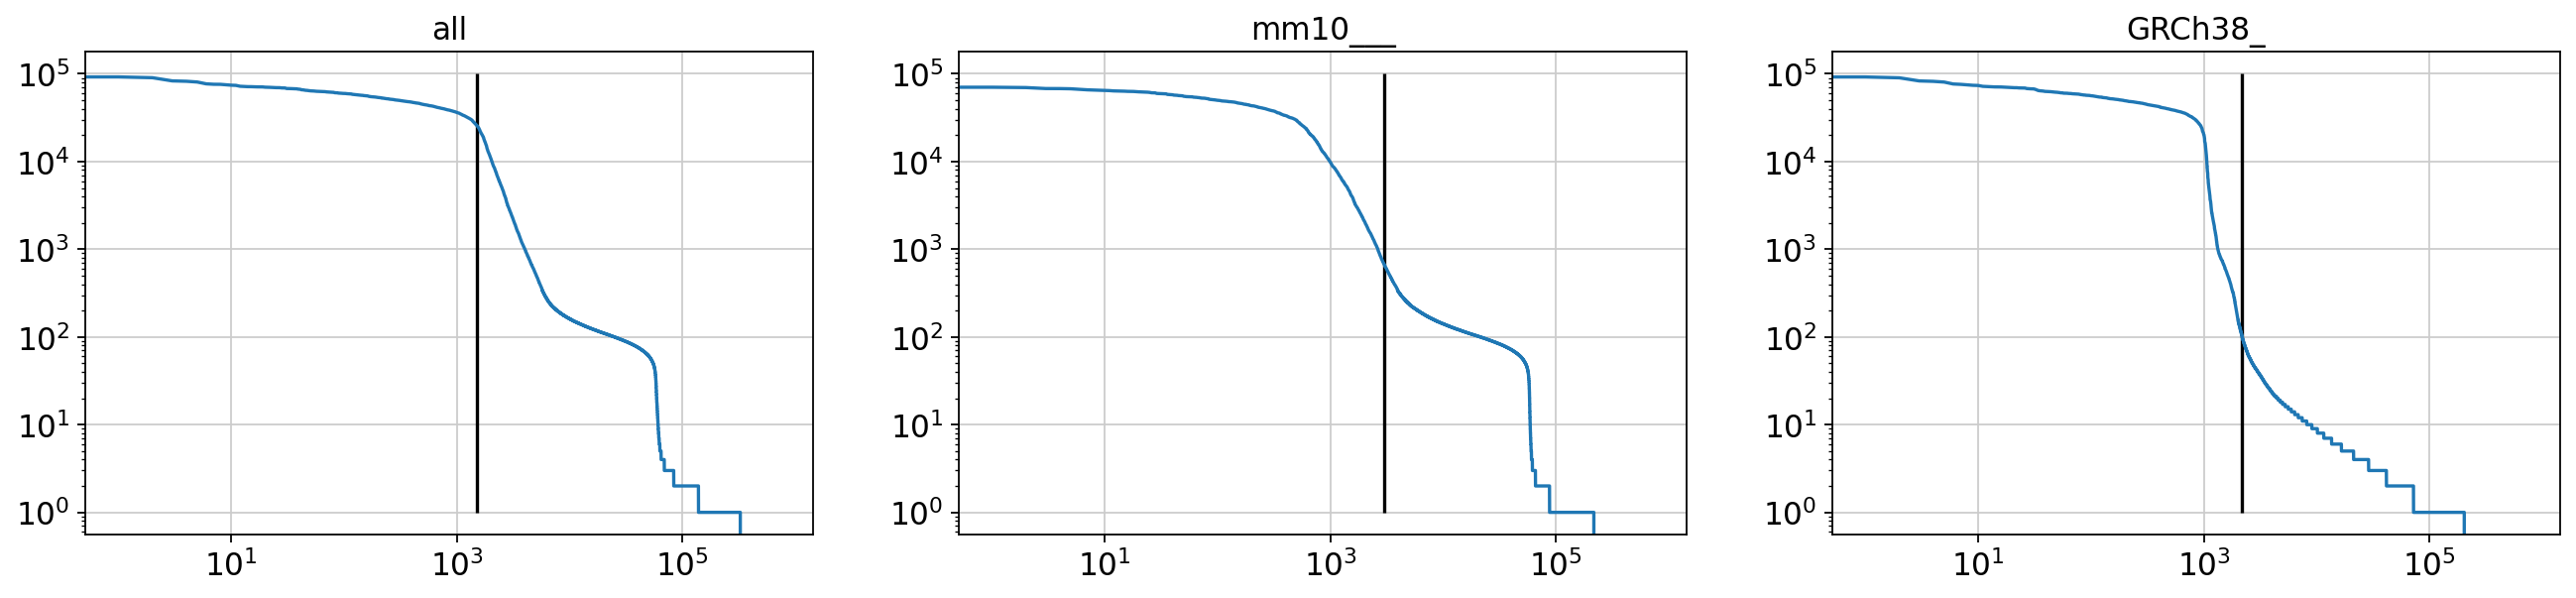

In [6]:
vlines=[1500, 3000, 2200]
fig, axes = plt.subplots(1,3,figsize=(20,4))
for var, ax, vline in zip(['all', 'mm10___', 'GRCh38_'], np.ravel(axes), vlines):
    if var == 'all': 
        ax.plot(np.sort(np.ravel(data['10x']['raw'].X.sum(1)))[::-1])
    else:
        ax.plot(np.sort(np.ravel(data['10x']['raw'][:,[i for i in data['10x']['raw'].var_names if i.startswith(var)]].X.sum(1)))[::-1])
    ax.set_title(var)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.vlines(vline,1,1e5, color='k')

In [7]:
data['10x']['raw'].obs['mouse_counts'] = data['10x']['raw'][:,[i for i in data['10x']['raw'].var_names if i.startswith('mm10___')]].X.sum(1)
data['10x']['raw'].obs['human_counts'] = data['10x']['raw'][:,[i for i in data['10x']['raw'].var_names if i.startswith('GRCh38_')]].X.sum(1)

Where to draw this is totally subjective. I realized with a value of `3000` I'm going deep into the mouse "knee", more than I would ordinarily.

In [8]:
mouse_thresh = 3000
human_thresh = 2200

In [9]:
mouse_only_cells = np.setdiff1d(data['10x']['raw'].obs['mouse_counts'].sort_values(ascending=False).index[:mouse_thresh].values,
                                data['10x']['raw'].obs['human_counts'].sort_values(ascending=False).index[:human_thresh].values)

In [10]:
data['10x']['mouse'] = data['10x']['raw'][:,[i for i in data['10x']['raw'].var_names if i.startswith('mm10___')]].copy()
data['10x']['mouse'].var_names = [i[7:] for i in data['10x']['mouse'].var_names]
data['10x']['mouse'] = data['10x']['mouse'][mouse_only_cells,:].copy()

In [11]:
data['XYZ']['mouse'] = data['XYZ']['raw'][data['XYZ']['raw'].obs['cell_call'] == 'M',:].copy()

In [12]:
data['10x']['mouse'].obs['mouse_counts']

AAACCTGAGAATGTGT-1    30535.0
AAACCTGAGGGTATCG-1      747.0
AAACCTGCAAGCTGAG-1    11212.0
AAACCTGCAGGGTTAG-1     9544.0
AAACCTGGTCGCTTCT-1     5291.0
                       ...   
TTTGTCAAGCCAACAG-1     4621.0
TTTGTCAAGTGGGTTG-1    48437.0
TTTGTCACATTACGAC-1     2598.0
TTTGTCAGTCCAGTGC-1     1466.0
TTTGTCATCAGGTTCA-1     2422.0
Name: mouse_counts, Length: 2900, dtype: float32

In [13]:
data['XYZ']['mouse'].obs['mouse_counts']

L20C1_P1A01F.CTCATACCTGCTACCT    5372.0
L20C1_P1A01F.GCGCTCCTTCCGCTAA    1256.0
L20C1_P1A02F.CGATAGCCTTATTGCT     700.0
L20C1_P1A02F.GTGCTCGTTAGGTTCT    1345.0
L20C1_P1A02F.TCAATTCGCGCACCGA     456.0
                                  ...  
L20C1_P4H12F.GGTAATGACTTGCAGA    3603.0
L20C1_P4H12F.GAGACATCCGGTATAC     544.0
L20C1_P4H12F.TTGGACGTGAGATAGT     934.0
L20C1_P4H12F.TCCACTGGAGTGTCGC     633.0
L20C1_P4H12F.TCCACCGTATGCGCTG     751.0
Name: mouse_counts, Length: 2389, dtype: float64

## Compare Counts

In [14]:
df_10x = pd.DataFrame(zip(it.repeat('10x'), data['10x']['mouse'].obs['mouse_counts']), columns=['method', 'counts'])
df_XYZ = pd.DataFrame(zip(it.repeat('XYZ'), data['XYZ']['mouse'].obs['mouse_counts']), columns=['method', 'counts'])

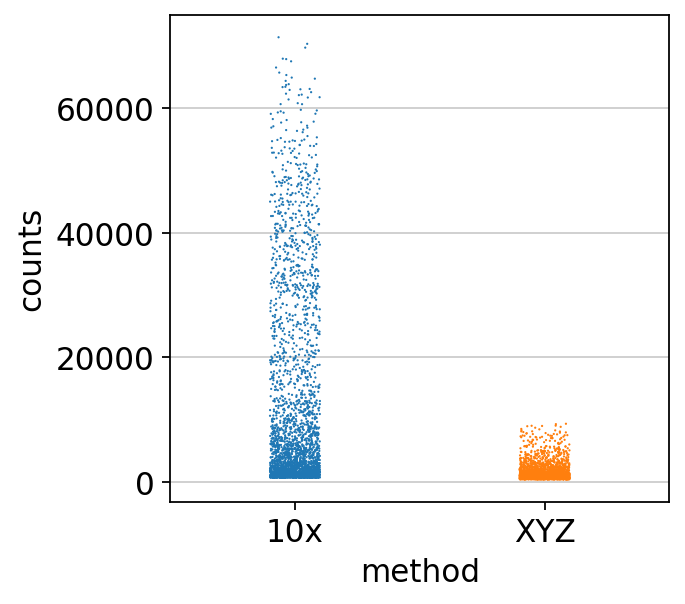

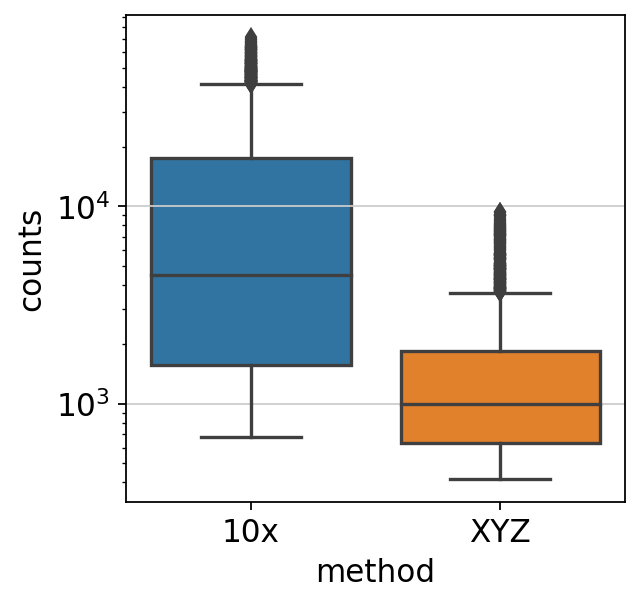

In [15]:
sns.stripplot(data=pd.concat([df_10x, df_XYZ]) ,y='counts',x='method',size=1);
plt.show()
sns.boxplot(data=pd.concat([df_10x, df_XYZ]), y='counts', x='method');
plt.yscale('log')
plt.show()

## Downsample

Here, I downsample by subtracting one from the entire 10x matrix until the mean is within 5% of the XYZeq matrix. 

In [16]:
mean_xyz = data['XYZ']['mouse'].obs['mouse_counts'].mean()
mean_10x = 0
eps = mean_xyz*0.05 # within 5% of the mean
sp = data['10x']['mouse'].X.toarray()
counter = 0
while abs(mean_10x - mean_xyz) > eps:
    sp -= 1
    sp = np.where(sp < 0, 0, sp) # one begs the question: could i have just done np.where(sp > 0, sp - 1, 0)
    counter += 1
    mean_10x = sp.sum(1).mean()
#     print(counter)
    if counter % 100 == 0:
        print(mean_10x)

1767.4576


In [17]:
data['10x']['mouse_down'] = data['10x']['mouse'].copy()
data['10x']['mouse_down'].X = sp
data['10x']['mouse_down'].obs['mouse_counts'] = data['10x']['mouse_down'].X.sum(1)

In [18]:
data['10x']['mouse_down'].obs['mouse_counts'].mean()

1623.6814

In [19]:
data['XYZ']['mouse'].obs['mouse_counts'].mean()

1554.0916701548765

In [25]:
df_10x = pd.DataFrame(zip(it.repeat('10x'), data['10x']['mouse_down'].obs['mouse_counts']), columns=['method', 'counts'])
df_XYZ = pd.DataFrame(zip(it.repeat('XYZ'), data['XYZ']['mouse'].obs['mouse_counts']), columns=['method', 'counts'])

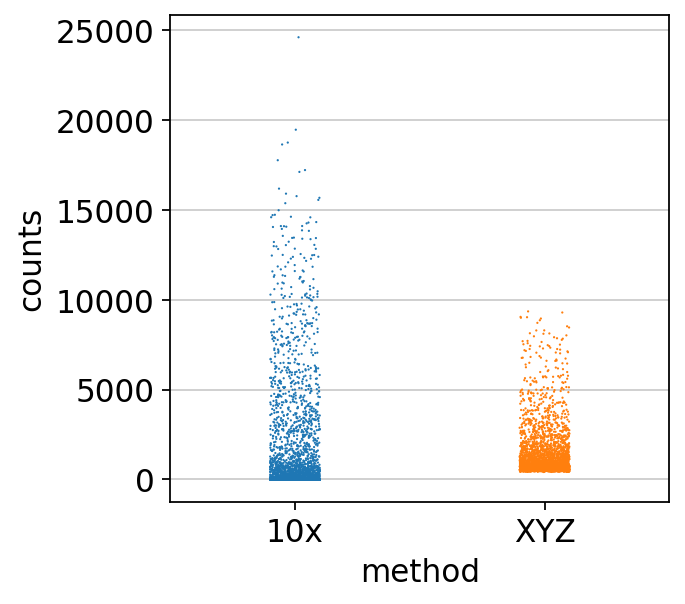

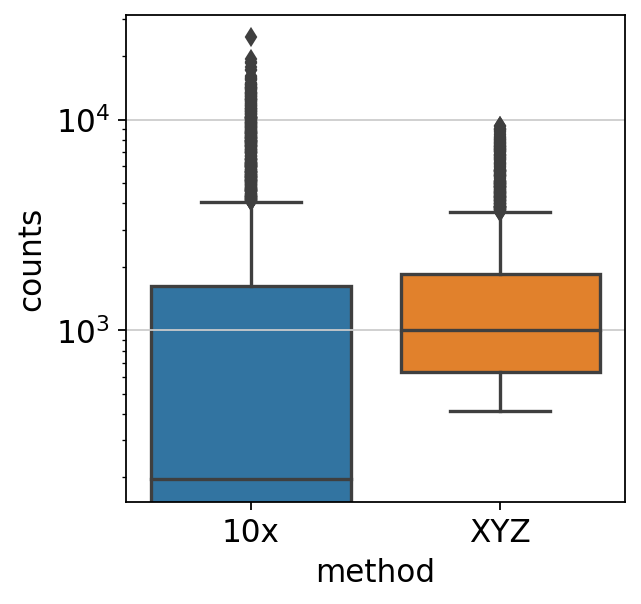

In [28]:
sns.stripplot(data=pd.concat([df_10x, df_XYZ]) ,y='counts',x='method',size=1);
plt.show()
sns.boxplot(data=pd.concat([df_10x, df_XYZ]), y='counts', x='method');
plt.yscale('log')
plt.show()

The means might be the same, but unfortunately the medians are way off.

## Filter for Percent Mito

In [29]:
genelist = data['10x']['mouse_down'].var_names.tolist()
mito_genes_names = [gn for gn in genelist if gn.startswith('mt-')]
mito_genes = [genelist.index(gn) for gn in mito_genes_names]
mito_counts = np.ravel(np.sum(data['10x']['mouse_down'][:, mito_genes].X, axis=1))

/home/ssm-user/anaconda3/envs/xyzeq/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/home/ssm-user/anaconda3/envs/xyzeq/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/ssm-user/anaconda3/envs/xyzeq/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


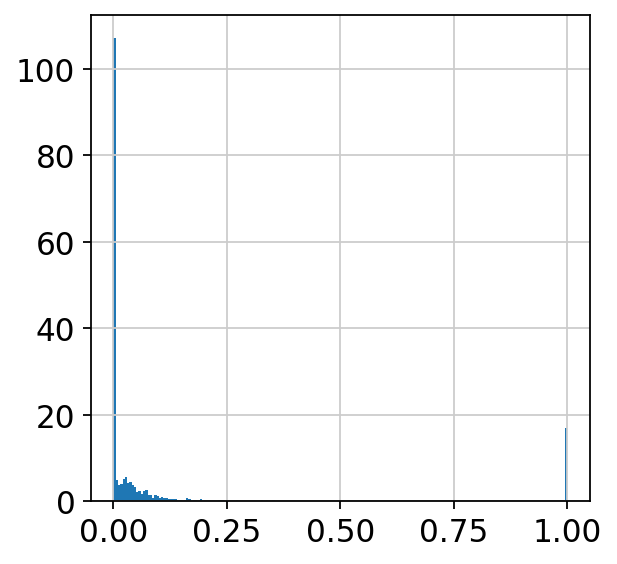

In [30]:
data['10x']['mouse_down'].obs['percent_mito'] = mito_counts / data['10x']['mouse_down'].obs['mouse_counts'].values
plt.hist(data['10x']['mouse_down'].obs['percent_mito'].values,bins=200,density=True);

In [31]:
data['10x']['mouse_down'] = data['10x']['mouse_down'][data['10x']['mouse_down'].obs['percent_mito'] < 0.25].copy()

## Filter for Genes

In [32]:
def my_plot(ax, vals, tupe=None, thresh=None, max_y=None, low=1e-1, hi=2e5):
    ax.hist(vals,bins=np.logspace(np.log10(low),np.log10(hi), 300)) # logspace bins looks great!
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_title(tupe)
    ax.grid(which='both', alpha=0.5)
    if thresh != None:
        ax.vlines(thresh,0,max_y)
    return

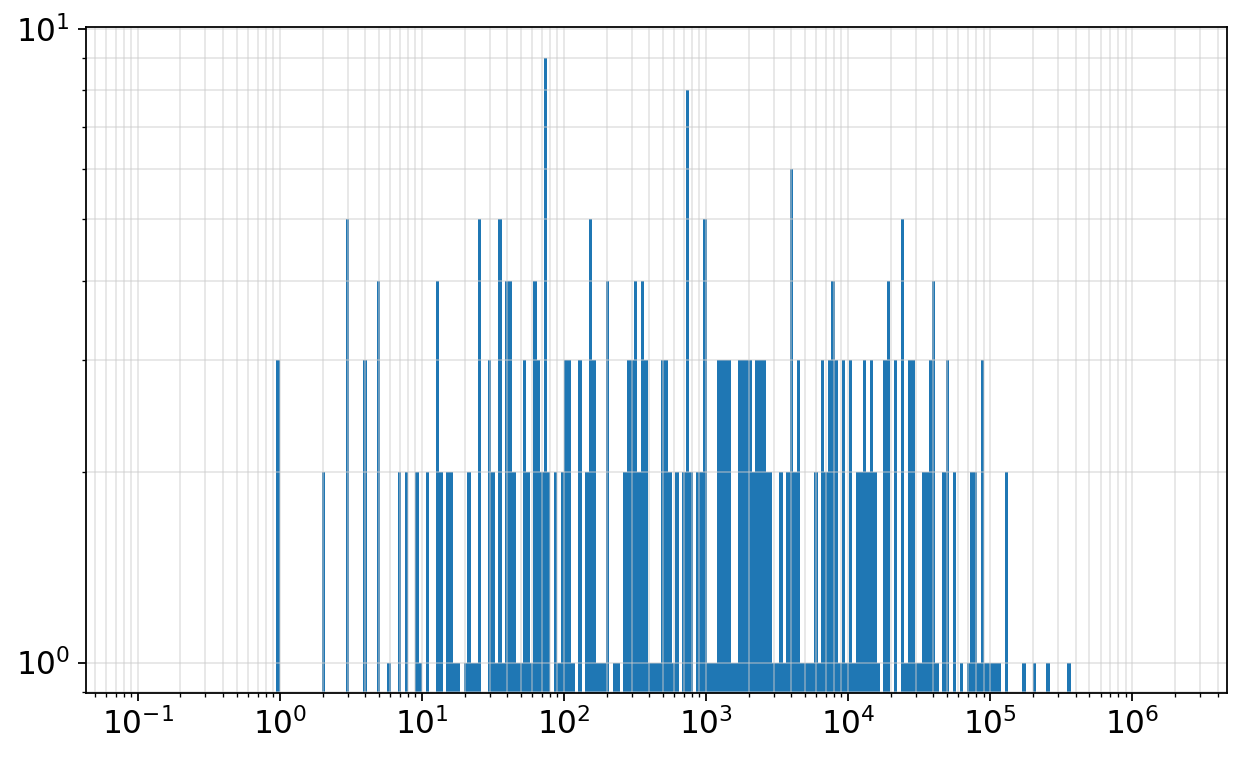

In [33]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
vals = sc.pp.filter_genes(data['10x']['mouse_down'], min_counts=0, inplace=False)[1] # total number of UMIs observed
my_plot(ax, vals, hi=2e6)
plt.tight_layout()

Going to leave this alone actually — no filtering.

## Normalize and Log

In [34]:
sc.pp.normalize_per_cell(data['10x']['mouse_down'])
sc.pp.log1p(data['10x']['mouse_down'])

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


## Dimension Reduction and Clustering

In [35]:
data['10x']['mouse_down_unscaled'] = data['10x']['mouse_down'].copy()

In [36]:
sc.pp.scale(data['10x']['mouse_down'], max_value=10)

    ... clipping at max_value 10


computing PCA
    with n_comps=100
    finished (0:00:04)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)


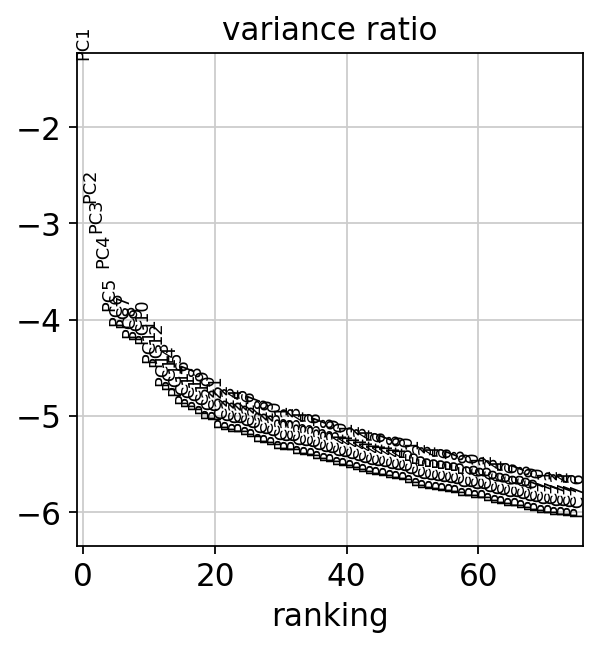

In [37]:
warnings.filterwarnings('ignore')
sc.pp.pca(data['10x']['mouse_down'],n_comps=100)
sc.pl.pca_variance_ratio(data['10x']['mouse_down'],log=True, n_pcs=75)
warnings.filterwarnings('default')

In [38]:
warnings.filterwarnings('ignore')
sc.pp.neighbors(data['10x']['mouse_down'], n_neighbors=15, n_pcs=30) # using all available embeddings, numba warning outlined here is not to be of concern: https://github.com/lmcinnes/umap/issues/252
warnings.filterwarnings('default')

computing neighbors
    computing neighbors
    using 'X_pca' with n_pcs = 30
    computed neighbors (0:00:00)
    computed connectivities (0:00:04)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)


In [39]:
sc.tl.umap(data['10x']['mouse_down'])

computing UMAP
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)


In [40]:
sc.tl.tsne(data['10x']['mouse_down'], n_pcs=30)

computing tSNE
    using 'X_pca' with n_pcs = 30
    using sklearn.manifold.TSNE with a fix by D. DeTomaso
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1763 samples in 0.004s...
[t-SNE] Computed neighbors for 1763 samples in 0.125s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1763
[t-SNE] Computed conditional probabilities for sample 1763 / 1763
[t-SNE] Mean sigma: 0.000003
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.830147
[t-SNE] KL divergence after 1000 iterations: 0.620292
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:05)


In [41]:
data['10x']['mouse_down']

AnnData object with n_obs × n_vars = 1763 × 31053
    obs: 'mouse_counts', 'human_counts', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'mean', 'std'
    uns: 'log1p', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [42]:
sc.tl.leiden(data['10x']['mouse_down'], resolution=0.1)

running Leiden clustering
    finished: found 10 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


... storing 'feature_types' as categorical
... storing 'genome' as categorical


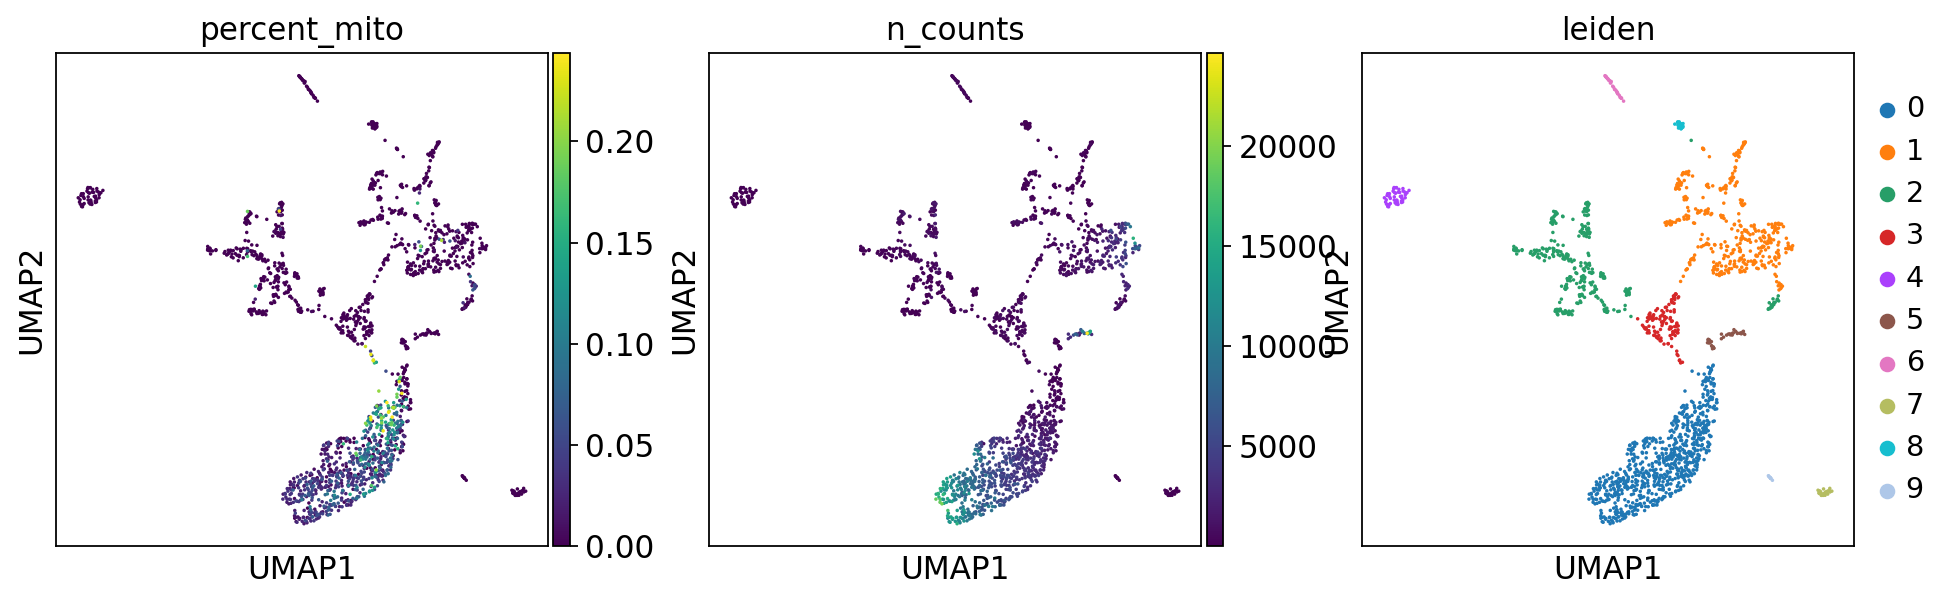

In [43]:
sc.pl.umap(data['10x']['mouse_down'],color=['percent_mito', 'n_counts', 'leiden'], size=10, palette=sc.pl.palettes.default_20)

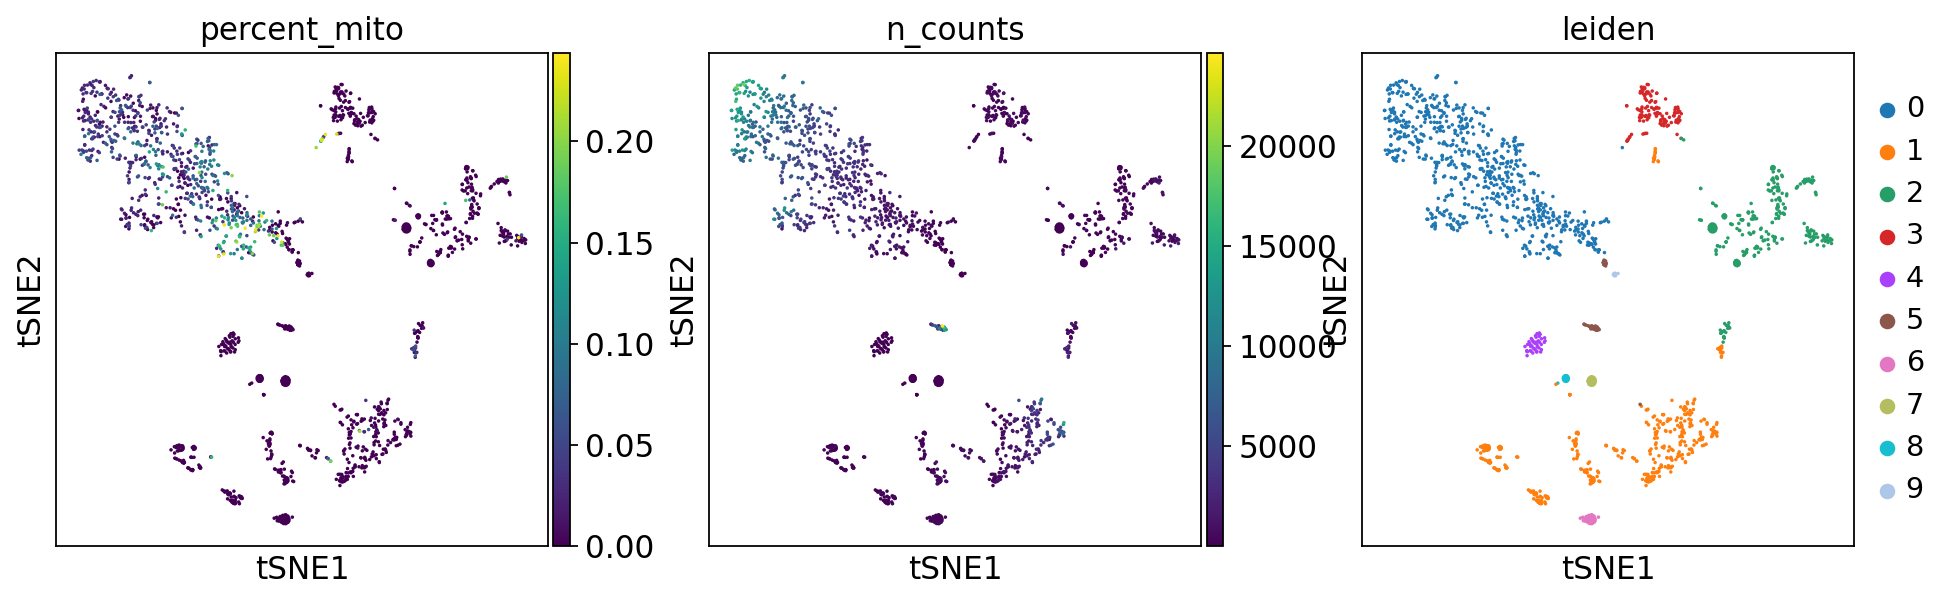

In [44]:
sc.pl.tsne(data['10x']['mouse_down'],color=['percent_mito', 'n_counts', 'leiden'], size=10, palette=sc.pl.palettes.default_20)

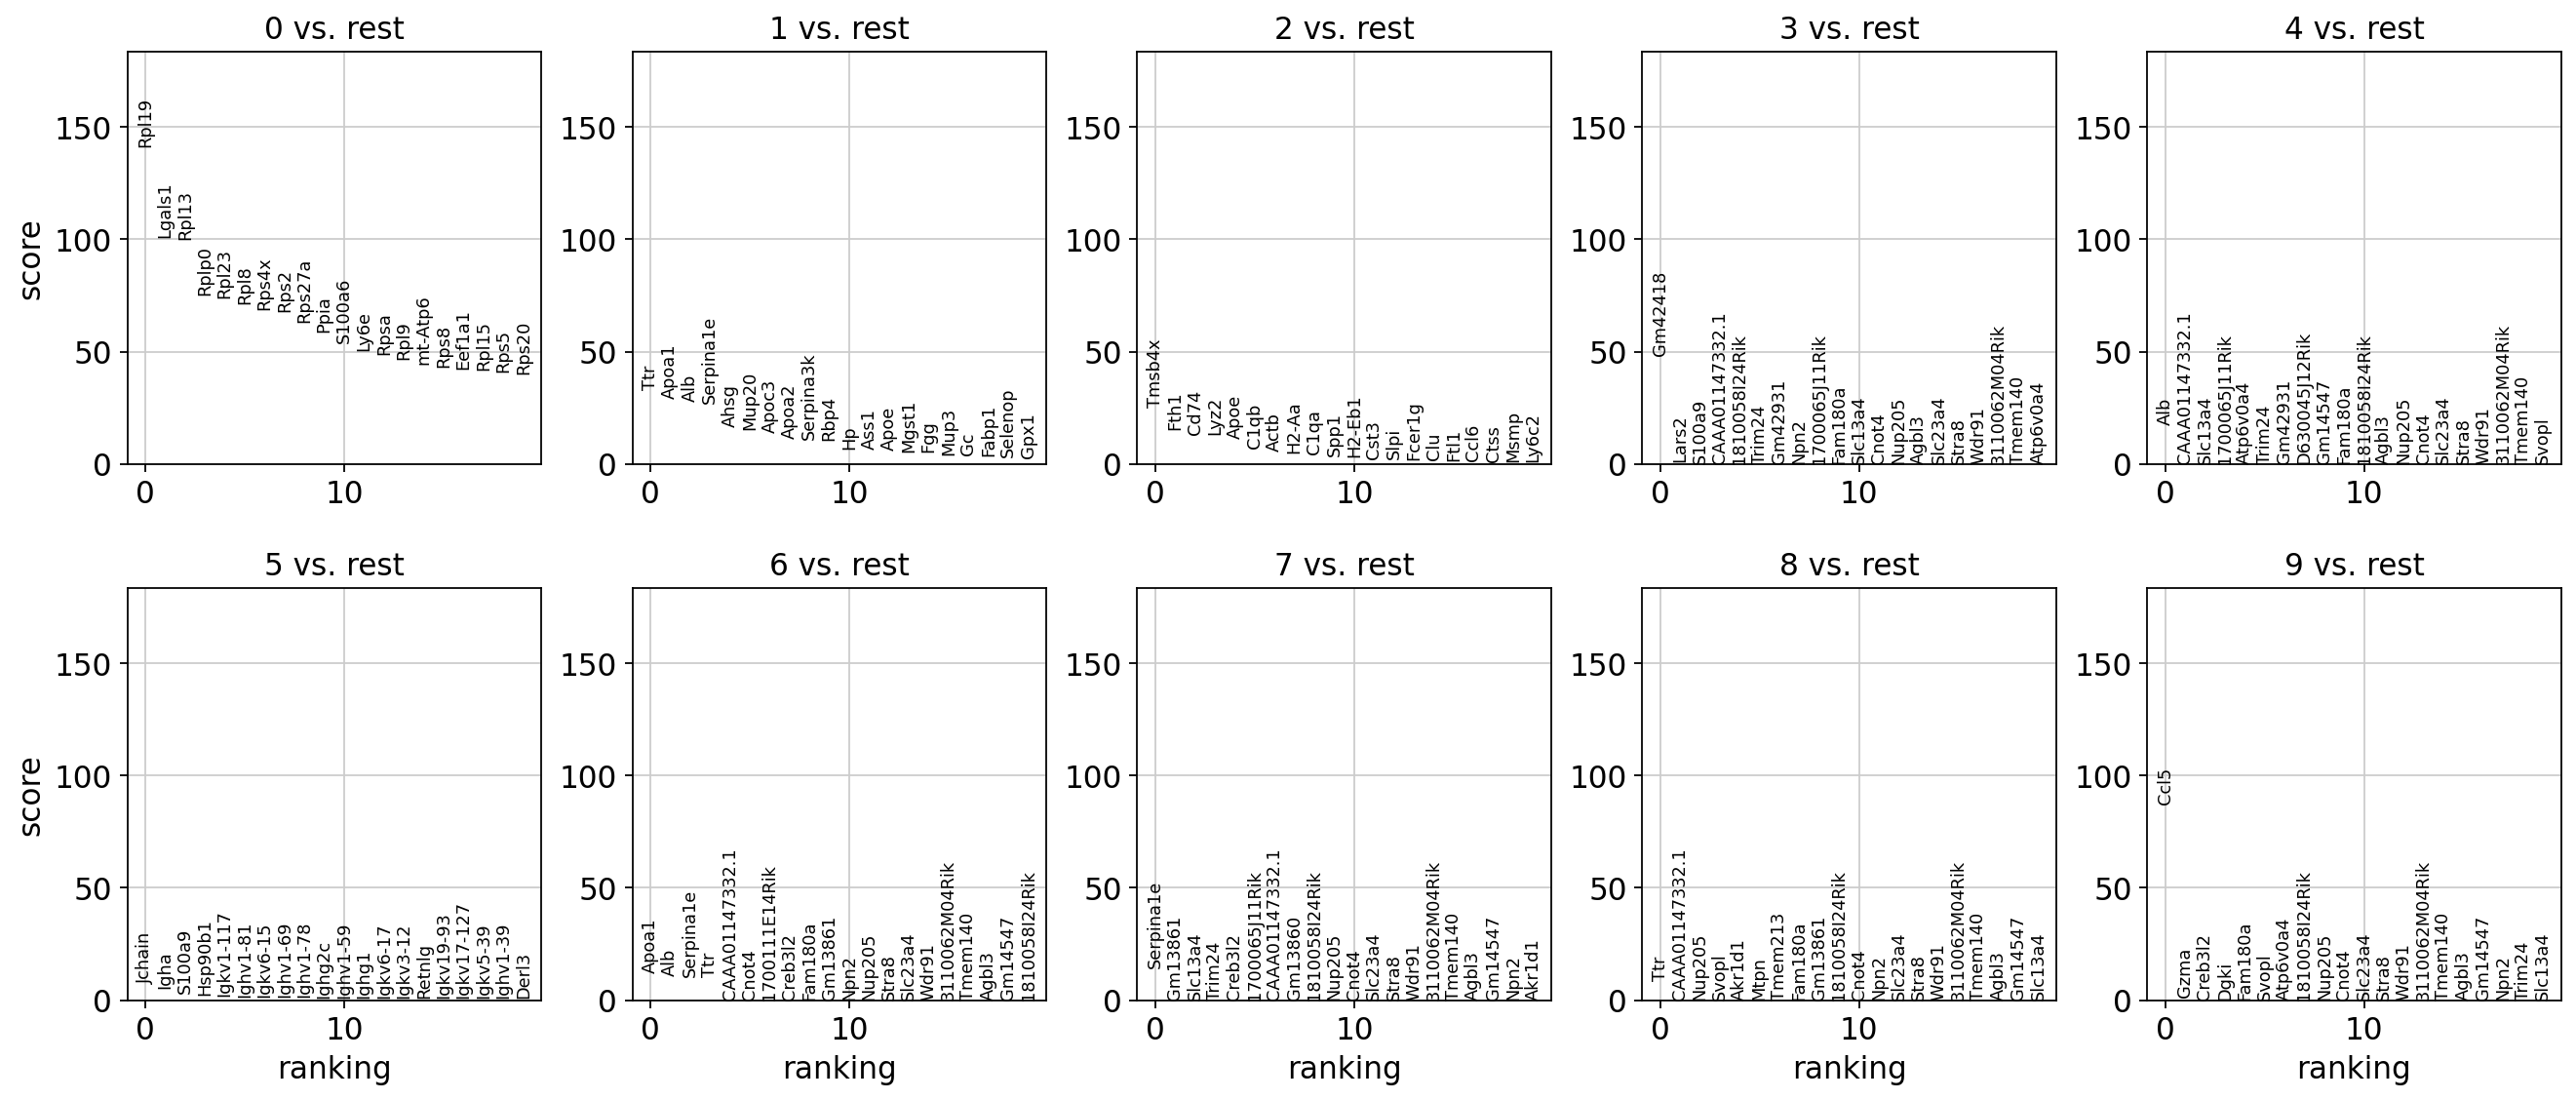

In [139]:
sc.settings.verbosity = 0 
warnings.filterwarnings('ignore')
sc.tl.rank_genes_groups(data['10x']['mouse_down'], groupby='leiden', n_genes=20)
warnings.filterwarnings('default')
sc.pl.rank_genes_groups(data['10x']['mouse_down'], ncols=5, n_genes=20)
sc.settings.verbosity = 4